<a href="https://colab.research.google.com/github/MatheusMnt/Music-Genre-Classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de Gêneros Musicias

Este trabalho apresenta a extração e seleção de características de sinais de áudio para a classificação automática de músicas por gênero musical. Utilizando o dataset GTZAN, foi aplicada a técnica de Random Forest para identificar as características mais relevantes. Após um pré-processamento envolvendo a segmentação das faixas de áudio, foram extraídas características dos sinais, e o modelo Random Forest foi treinado e avaliado. O modelo atingiu uma acurácia de 72,26\% sem perturbações no sinal e 70,88\% quando ruído e eco foram adicionados. Além disso, foram analisadas as características mais influentes para a predição, permitindo um melhor entendimento dos padrões acústicos.

Grupo:\
Antônio Apolinário (aab2@cin.ufpe.br)\
Mariana Melo (mms11@cin.ufpe.br) \
Matheus Augusto (mams4@cin.ufpe.br)

# Imports

In [ ]:
import os
import time
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from IPython.display import Audio
from tqdm import tqdm
from joblib import Parallel, delayed
from numba import jit
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from google.colab import files


# Importando Dados



In [ ]:
# Clonar o repositório do GitHub
!git clone https://github.com/MatheusMnt/Music-Genre-Classification.git

# Acessar a pasta do repositório
%cd Music-Genre-Classification

# (Opcional) Verificar os arquivos disponíveis
!ls


Cloning into 'Music-Genre-Classification'...
remote: Enumerating objects: 2001, done.
remote: Total 2001 (delta 0), reused 0 (delta 0), pack-reused 2001 (from 2)
Receiving objects: 100% (2001/2001), 1.19 GiB | 17.67 MiB/s, done.
Updating files: 100% (2002/2002), done.
/content/Music-Genre-Classification
Data  README.md


## Verificando se os dados foram Importados Corretamente

In [ ]:
file_path = "Data/features_30_sec.csv"  # Ajuste para o nome correto do arquivo
df = pd.read_csv(file_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [ ]:
print(df[['filename', 'label']])
print(df.info())

            filename  label
0    blues.00000.wav  blues
1    blues.00001.wav  blues
2    blues.00002.wav  blues
3    blues.00003.wav  blues
4    blues.00004.wav  blues
..               ...    ...
995   rock.00095.wav   rock
996   rock.00096.wav   rock
997   rock.00097.wav   rock
998   rock.00098.wav   rock
999   rock.00099.wav   rock

[1000 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   f

In [ ]:
#  Diretório onde os arquivos .wav estão armazenados
base_path = "Data/genres_original/"

#  Seleciona o arquivo da coluna 'filename' e ajusta o caminho
path = os.path.join(base_path, df['label'].iloc[0])  # Combina o diretório base com o genero
file_path = os.path.join(path, df['filename'].iloc[0]) # Combina o diretório base com o nome do Arquivo

# Reproduz o arquivo de áudio
display(Audio(filename=file_path, autoplay=True))

# Extração de Características

## Determinando Melhores Características para Serem Extraídas

Utilizamos o Algoritmo Random Forest para deternubar quais as melhores características a serem extraídas de forma a aumentar a ácurácia do Algoritmo de classificação.

Acurácia do modelo: 88.29%
                    Feature  Importance
16             perceptr_var    0.049480
1          chroma_stft_mean    0.036692
4                   rms_var    0.036440
3                  rms_mean    0.032749
24               mfcc4_mean    0.030803
9              rolloff_mean    0.029650
7   spectral_bandwidth_mean    0.029431
15            perceptr_mean    0.027238
18               mfcc1_mean    0.025630
14              harmony_var    0.025062


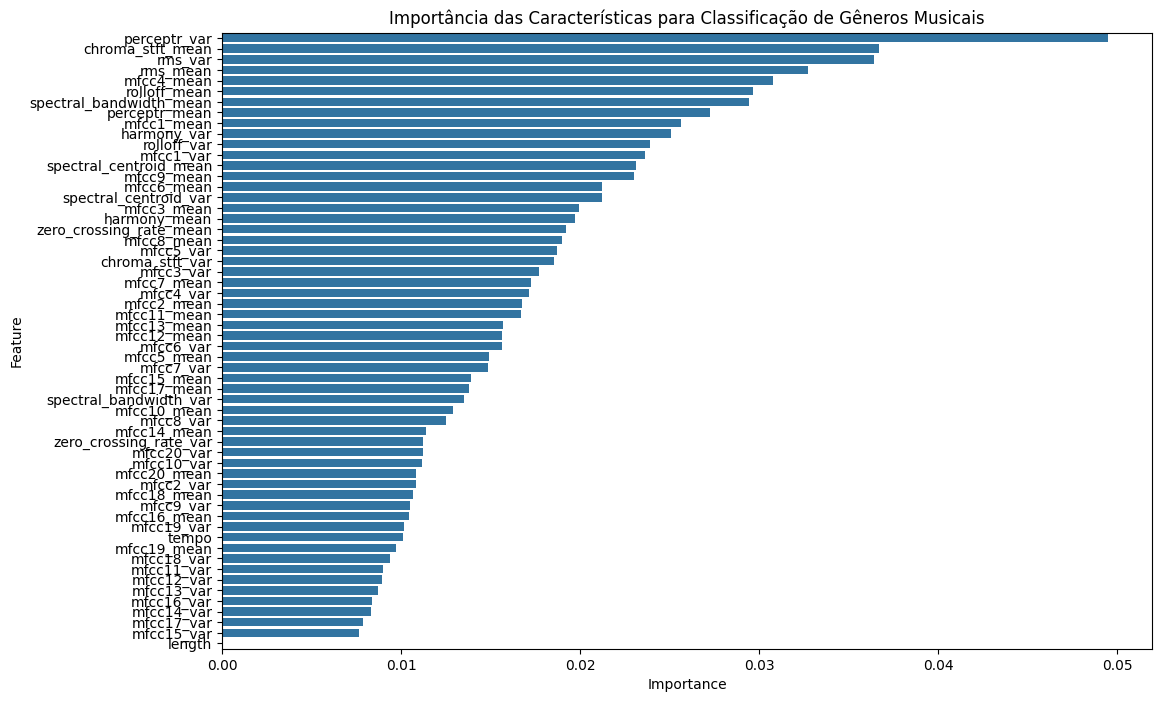

In [ ]:
# Carregar o arquivo CSV com as características extraídas
csv_path = 'Data/features_3_sec.csv'
data = pd.read_csv(csv_path)

# Ver as primeiras linhas para inspecionar
# print(data.head())

# Separar as características (X) e os rótulos (y)
X = data.drop(columns=['label', 'filename'])  # Assume que a coluna 'genre' contém o rótulo do gênero musical
y = data['label']


# Dividir em dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy * 100:.2f}%')

# Obter a importância das características
feature_importance = model.feature_importances_

# Criar um DataFrame com a importância das características
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Ordenar as características por importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Exibir as características mais importantes
print(importance_df.head(10))

# Plotar a importância das características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importância das Características para Classificação de Gêneros Musicais')
plt.show()


## Extraindo Características

A extração de características foi realizada para capturar informações representativas da estrutura harmônica e espectral dos sinais de áudio. Foram utilizadas as seguintes métricas:

- **Energia perceptual (perceptr_var e perceptr_mean):**  
  Mede a distribuição de energia ao longo do espectro de frequência, permitindo identificar padrões de intensidade sonora característicos de cada gênero musical.

- **Coeficientes Cepstrais de Frequência Mel (MFCCs):**  
  Extraem representações da envoltória espectral do sinal, sendo amplamente utilizados em tarefas de classificação de áudio.

- **Espectro de Fourier (fft_mean e fft_var):**  
  A Transformada de Fourier decompõe o sinal em suas componentes espectrais, auxiliando na distinção entre gêneros musicais que possuem padrões r


In [ ]:
# Configurações
BASE_PATH = "Data/genres_original/"
SEGMENT_DURATION = 3  # 3 segundos
N_SAMPLES = 400  # Número de amostras por gênero
FEATURES_TO_EXTRACT = [
    "perceptr_var", "chroma_stft_mean", "rms_var", "rms_mean", "mfcc4_mean",
    "fft_mean", "fft_var", "rolloff_mean", "spectral_bandwidth_mean", "perceptr_mean",
    "mfcc1_mean", "harmony_var"
]

In [ ]:
# Otimiza chamada de funções da NumPy
@jit(nopython=True, fastmath=True)
def compute_variance(arr):
    """Cálculo otimizado de variância para arrays NumPy."""
    return np.var(arr)

@jit(nopython=True, fastmath=True)
def compute_mean(arr):
    """Cálculo otimizado de média para arrays NumPy."""
    return np.mean(arr)

### Pré-Processamento: Segmentação dos aúdios

Cada faixa de áudio (30 segundos) foi dividida em segmentos de 3 segundos, e foram selecionados aleatoriamente 400 segmentos de cada gênero, totalizando 4000 amostras. Para garantir a preservação de informações relevantes e evitar perdas entre segmentos, foi utilizada a técnica de sobreposição de janela (overlap), permitindo maior continuidade temporal e melhor captura das características acústicas.

Além disso, as características extraídas foram representadas utilizando a escala de frequência Mel, através do Mel Spectrograma, que aproxima a percepção auditiva humana. Essa técnica reduz a dimensionalidade dos dados e enfatiza frequências mais relevantes para a distinção entre gêneros musicais.


In [ ]:
def process_audio_file(file_path, segment_duration):
    """Processa um arquivo de áudio e retorna seus segmentos de forma eficiente."""
    try:
        # Carrega apenas a duração do áudio para decidir se vale a pena carregar completamente
        duration = librosa.get_duration(path=file_path)
        if duration < segment_duration:
            return []

        y, sr = librosa.load(file_path, sr=None, mono=True)
        num_segments = int(duration // segment_duration)

        segments = [
            (y[i * sr * segment_duration : (i + 1) * sr * segment_duration], sr)
            for i in range(num_segments)
        ]
        return segments

    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return []

In [ ]:
def divide_audio_in_segments(base_path, segment_duration):
    """ Divide os áudios em segmentos e armazena os segmentos em um dicionário de forma otimizada."""
    genres = [g for g in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, g))]
    segments = {genre: [] for genre in genres}

    file_paths = [
        (os.path.join(base_path, genre, f), genre)
        for genre in genres
        for f in os.listdir(os.path.join(base_path, genre)) if f.endswith('.wav')
    ]

    results = Parallel(n_jobs=-1)(
        delayed(process_audio_file)(file, segment_duration) for file, genre in tqdm(file_paths, desc="Processando áudios")
    )

    for (file, genre), segment_list in zip(file_paths, results):
        segments[genre].extend(segment_list)

    return segments


### Função de Extração

In [ ]:
def extract_features_from_segments(segments):
    """ Extrai características de forma otimizada."""
    data, labels = [], []

    for genre, segment_list in tqdm(segments.items(), desc="Extraindo características"):
        random.shuffle(segment_list)
        selected_segments = segment_list[:N_SAMPLES]

        for segment, sr in selected_segments:
            harmonic = librosa.effects.harmonic(segment)
            rms = librosa.feature.rms(y=segment)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)

            fft_transform = fft.fft(segment)
            fft_abs = np.abs(fft_transform)

            # Cálculos otimizados
            perceptr_var = compute_variance(harmonic)
            chroma_stft_mean = compute_mean(librosa.feature.chroma_stft(y=segment, sr=sr))
            rms_var = compute_variance(rms)
            rms_mean = compute_mean(rms)
            mfcc4_mean = compute_mean(mfcc[3])
            rolloff_mean = compute_mean(rolloff)
            spectral_bandwidth_mean = compute_mean(spectral_bandwidth)
            perceptr_mean = compute_mean(harmonic)
            mfcc1_mean = compute_mean(mfcc[1])
            harmony_var = compute_variance(harmonic)
            fft_mean = compute_mean(fft_abs)
            fft_var = compute_variance(fft_abs)

            data.append([
                perceptr_var, chroma_stft_mean, rms_var, rms_mean, mfcc4_mean,
                fft_mean, fft_var, rolloff_mean, spectral_bandwidth_mean,
                perceptr_mean, mfcc1_mean, harmony_var
            ])
            labels.append(genre)

    return pd.DataFrame(data, columns=FEATURES_TO_EXTRACT), labels

## Executando Extração

In [ ]:
# Executando as funções otimizadas
segments = divide_audio_in_segments(BASE_PATH, SEGMENT_DURATION)
df_features, labels = extract_features_from_segments(segments)
df_features["genre"] = labels  # Adiciona a coluna de gênero

print("Processo concluído!")
print(df_features.head())

Extraindo características: 100%|██████████| 10/10 [17:03<00:00, 102.39s/it]

Processo concluído!
   perceptr_var  chroma_stft_mean   rms_var  rms_mean  mfcc4_mean  fft_mean  \
0      0.000168          0.236987  0.000027  0.012390   37.183992  0.593092   
1      0.000041          0.179661  0.000005  0.006355   17.169847  0.535897   
2      0.000480          0.287695  0.000150  0.024511   34.008282  2.393690   
3      0.000148          0.285617  0.000030  0.011787   35.463833  0.979691   
4      0.000479          0.239272  0.000029  0.022257   31.960607  1.029346   

     fft_var  rolloff_mean  spectral_bandwidth_mean  perceptr_mean  \
0  11.718994   1906.930777              1393.447162      -0.000077   
1   2.785014   3402.660194              1777.089087       0.000158   
2  45.918315   2351.508601              1319.372929       0.000135   
3  10.318157   2846.606633              1607.897444      -0.000008   
4  33.993257   1320.813552              1100.496345      -0.000006   

   mfcc1_mean  harmony_var      genre  
0  162.298332     0.000168  classical  
1  1

### Avaliando Tempo de Extração de cada Característica

In [ ]:
def extract_features_with_timing(segment, sr):
    """ Mede o tempo de extração de cada característica """
    timings = {}

    start = time.perf_counter()
    harmonic = librosa.effects.harmonic(segment)
    timings["harmonic"] = time.perf_counter() - start

    start = time.perf_counter()
    rms = librosa.feature.rms(y=segment)
    timings["rms"] = time.perf_counter() - start

    start = time.perf_counter()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
    timings["spectral_bandwidth"] = time.perf_counter() - start

    start = time.perf_counter()
    rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
    timings["rolloff"] = time.perf_counter() - start

    start = time.perf_counter()
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
    timings["mfcc"] = time.perf_counter() - start

    start = time.perf_counter()
    fft_transform = fft.fft(segment)
    fft_abs = np.abs(fft_transform)
    timings["fft"] = time.perf_counter() - start

    return timings

# Teste com um único segmento
sample_segment, sample_sr = segments["blues"][0]  # Pegando um segmento qualquer
timing_results = extract_features_with_timing(sample_segment, sample_sr)

# Ordenando e imprimindo os tempos
sorted_timings = sorted(timing_results.items(), key=lambda x: x[1], reverse=True)
for feature, time_taken in sorted_timings:
    print(f"{feature}: {time_taken:.6f} segundos")


harmonic: 0.227181 segundos
mfcc: 0.076364 segundos
spectral_bandwidth: 0.008220 segundos
rolloff: 0.006802 segundos
fft: 0.002032 segundos
rms: 0.000794 segundos


# Classificação

Acurácia do modelo: 71.00%


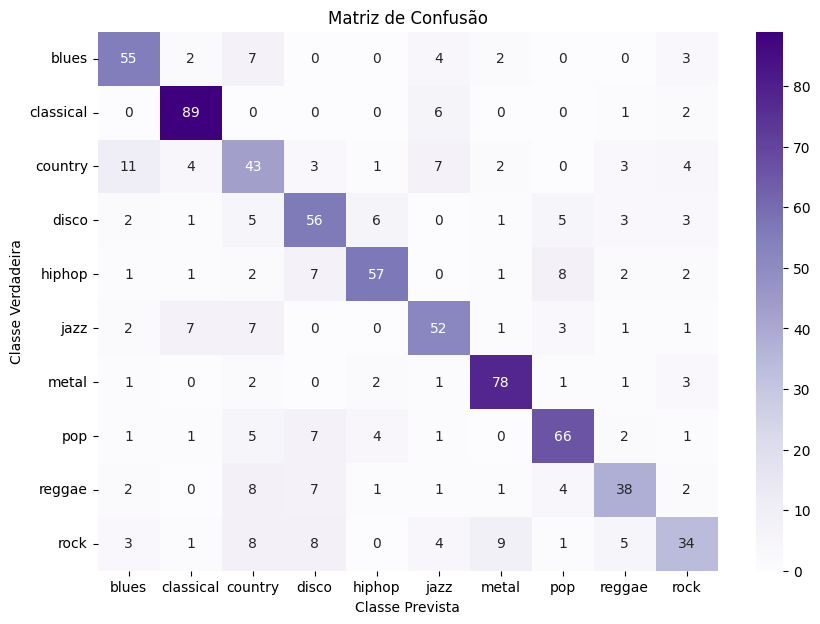

Relatório de Classificação:
              precision    recall  f1-score   support

       blues       0.71      0.75      0.73        73
   classical       0.84      0.91      0.87        98
     country       0.49      0.55      0.52        78
       disco       0.64      0.68      0.66        82
      hiphop       0.80      0.70      0.75        81
        jazz       0.68      0.70      0.69        74
       metal       0.82      0.88      0.85        89
         pop       0.75      0.75      0.75        88
      reggae       0.68      0.59      0.63        64
        rock       0.62      0.47      0.53        73

    accuracy                           0.71       800
   macro avg       0.70      0.70      0.70       800
weighted avg       0.71      0.71      0.71       800



In [ ]:
# Dividir em treino e teste
X = df_features.drop(columns=["genre"])
y = pd.Series(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar o classificador Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o modelo
rf_classifier.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_classifier.predict(X_test)

# Avaliar a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy * 100:.2f}%")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Matriz de Confusão")
plt.ylabel("Classe Verdadeira")
plt.xlabel("Classe Prevista")
plt.show()

# Classification Report
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

## Função para classificação de Aúdio Arbitrário

In [ ]:
def classify_audio(file_path, model, feature_columns):
    """
    Classifica um arquivo de áudio usando o modelo já treinado.

    Parâmetros:
    - file_path (str): Caminho do arquivo de áudio a ser classificado.
    - model: Modelo treinado para classificação.
    - feature_columns (list): Lista com os nomes das colunas de características usadas no treinamento.

    Retorna:
    - Gênero previsto.
    """
    try:
        # Carregar o áudio
        y, sr = librosa.load(file_path, sr=None, mono=True)

        # Extrair características
        harmonic = librosa.effects.harmonic(y)
        rms = librosa.feature.rms(y=y)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        fft_transform = np.fft.fft(y)
        fft_abs = np.abs(fft_transform)

        # Criar vetor de características
        features = [
            np.var(harmonic),
            np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
            np.var(rms),
            np.mean(rms),
            np.mean(mfcc[3]),
            np.mean(fft_abs),
            np.var(fft_abs),
            np.mean(rolloff),
            np.mean(spectral_bandwidth),
            np.mean(harmonic),
            np.mean(mfcc[1]),
            np.var(harmonic)
        ]

        # Transformar em DataFrame para manter a mesma estrutura usada no treinamento
        df_audio = pd.DataFrame([features], columns=feature_columns)

        # Fazer a predição
        predicted_genre = model.predict(df_audio)[0]

        return predicted_genre

    except Exception as e:
        print(f"Erro ao processar o arquivo {file_path}: {e}")
        return None



## Buscando os Melhores Hiperparâmetros (Não precisa rodar novamente)

In [ ]:
# Definição dos hiperparâmetros para teste
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árvores
    'max_depth': [None, 10, 20],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de amostras em cada folha
}

# Inicializar o classificador
rf = RandomForestClassifier(random_state=42)

# Aplicar GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_rf = grid_search.best_estimator_
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Testar no conjunto de teste
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia após ajuste: {accuracy * 100:.2f}%")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Melhores parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Acurácia após ajuste: 71.38%


# Adição de Ruído e Eco

Para avaliar a robustez do modelo, foram adicionados ruído e eco a 10 amostras de áudio do conjunto de teste. Após a extração de características e nova avaliação com o Random Forest, a acurácia obtida foi de 70,88\%.

In [ ]:
# Criar pasta para salvar áudios modificados
MODIFIED_AUDIO_PATH = "modified_audio"
os.makedirs(MODIFIED_AUDIO_PATH, exist_ok=True)

# Função para adicionar eco (eco mais intenso e persistente)
def add_echo(audio, sr, delay=0.3, decay=0.7, repetitions=3):
    num_samples_delay = int(delay * sr)
    echo_signal = np.zeros_like(audio)

    for i in range(1, repetitions + 1):
        start_idx = i * num_samples_delay
        if start_idx < len(audio):
            echo_signal[start_idx:] += audio[:-start_idx] * (decay ** i)

    return audio + echo_signal

# Função para adicionar ruído branco (ruído mais forte)
def add_noise(audio, noise_level=0.05):
    noise = np.random.randn(len(audio)) * noise_level
    return audio + noise

# Caminho do dataset
GENRES_PATH = "/content/gtzan_dataset/Data/genres_original/"
genres = os.listdir(GENRES_PATH)

# Lista de arquivos escolhidos arbitrariamente
selected_files = [
    "/content/gtzan_dataset/Data/genres_original/classical/classical.00001.wav",
    "/content/gtzan_dataset/Data/genres_original/disco/disco.00014.wav",
    "/content/gtzan_dataset/Data/genres_original/metal/metal.00081.wav"
]

# Selecionar mais 7 músicas aleatoriamente
while len(selected_files) < 10:
    genre = random.choice(genres)
    genre_path = os.path.join(GENRES_PATH, genre)
    files = [f for f in os.listdir(genre_path) if f.endswith(".wav")]
    selected_file = random.choice(files)
    file_path = os.path.join(genre_path, selected_file)

    # Garantir que não repetimos arquivos
    if file_path not in selected_files:
        selected_files.append(file_path)

# Processar os áudios escolhidos
new_data = []
new_labels = []

for file_path in selected_files:
    # Carregar a música original
    y, sr = librosa.load(file_path, sr=None, mono=True)
    genre = file_path.split("/")[-2]  # Extrair o gênero do caminho
    file_name = file_path.split("/")[-1].replace(".wav", "")  # Nome do arquivo sem extensão

    print(f"Música original Alterada: {file_path}")

    # Criar versões alteradas
    y_echo = add_echo(y, sr)
    y_noise = add_noise(y)

    # Salvar áudios modificados na pasta "modified_audio"
    sf.write(os.path.join(MODIFIED_AUDIO_PATH, f"{file_name}_echo.wav"), y_echo, sr)
    sf.write(os.path.join(MODIFIED_AUDIO_PATH, f"{file_name}_noise.wav"), y_noise, sr)

    # Extrair características das músicas alteradas
    for modified_audio in [y_echo, y_noise]:
        harmonic = librosa.effects.harmonic(modified_audio)
        rms = librosa.feature.rms(y=modified_audio)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=modified_audio, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=modified_audio, sr=sr)
        mfcc = librosa.feature.mfcc(y=modified_audio, sr=sr, n_mfcc=13)
        fft_transform = np.fft.fft(modified_audio)
        fft_abs = np.abs(fft_transform)

        # Criar vetor de características
        features = [
            np.var(harmonic),
            np.mean(librosa.feature.chroma_stft(y=modified_audio, sr=sr)),
            np.var(rms),
            np.mean(rms),
            np.mean(mfcc[3]),
            np.mean(fft_abs),
            np.var(fft_abs),
            np.mean(rolloff),
            np.mean(spectral_bandwidth),
            np.mean(harmonic),
            np.mean(mfcc[1]),
            np.var(harmonic)
        ]
        new_data.append(features)
        new_labels.append(genre)

# Criar dataframe com os novos dados
df_new = pd.DataFrame(new_data, columns=[
    "perceptr_var", "chroma_stft_mean", "rms_var", "rms_mean", "mfcc4_mean",
    "fft_mean", "fft_var", "rolloff_mean", "spectral_bandwidth_mean",
    "perceptr_mean", "mfcc1_mean", "harmony_var"
])
df_new["genre"] = new_labels


Música original Alterada: /content/gtzan_dataset/Data/genres_original/classical/classical.00001.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/disco/disco.00014.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/metal/metal.00081.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/reggae/reggae.00014.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/jazz/jazz.00053.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/jazz/jazz.00035.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/metal/metal.00015.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/hiphop/hiphop.00010.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/hiphop/hiphop.00094.wav
Música original Alterada: /content/gtzan_dataset/Data/genres_original/metal/metal.00041.wav


## Avaliando o Modelo com adição de Ruído e Eco

Acurácia do modelo atualizado: 70.12%


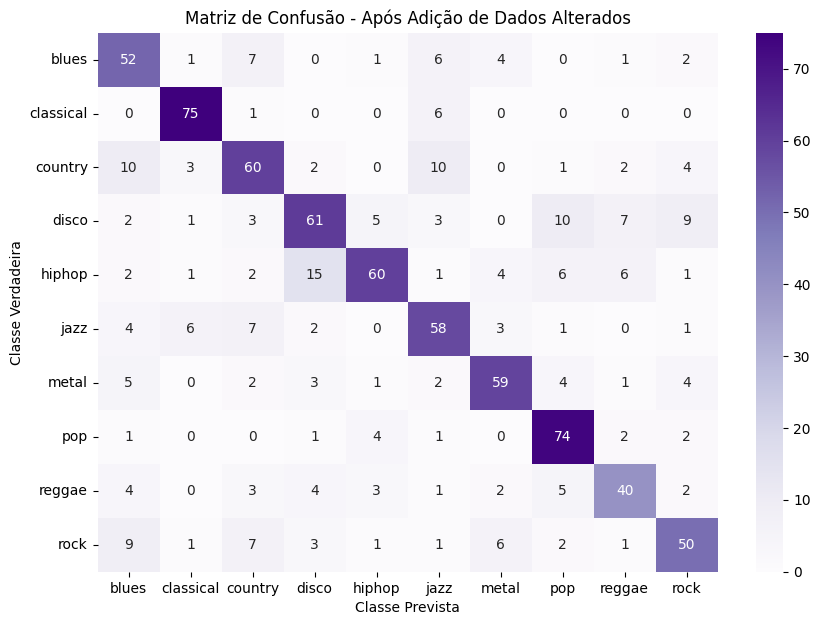

Relatório de Classificação Atualizado:
              precision    recall  f1-score   support

       blues       0.58      0.70      0.64        74
   classical       0.85      0.91      0.88        82
     country       0.65      0.65      0.65        92
       disco       0.67      0.60      0.64       101
      hiphop       0.80      0.61      0.69        98
        jazz       0.65      0.71      0.68        82
       metal       0.76      0.73      0.74        81
         pop       0.72      0.87      0.79        85
      reggae       0.67      0.62      0.65        64
        rock       0.67      0.62      0.64        81

    accuracy                           0.70       840
   macro avg       0.70      0.70      0.70       840
weighted avg       0.70      0.70      0.70       840



In [ ]:
# Atualizar conjunto de teste
X_test = pd.concat([X_test, df_new.drop(columns=["genre"])], ignore_index=True)
y_test = pd.concat([y_test, df_new["genre"]], ignore_index=True)

# Fazer previsões no conjunto atualizado
y_pred = rf_classifier.predict(X_test)

# Avaliar o modelo atualizado
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo atualizado: {accuracy * 100:.2f}%")

# Matriz de Confusão
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Matriz de Confusão - Após Adição de Dados Alterados")
plt.ylabel("Classe Verdadeira")
plt.xlabel("Classe Prevista")
plt.show()

# Relatório de Classificação
print("Relatório de Classificação Atualizado:")
print(classification_report(y_test, y_pred))

# Testes Arbitrários

In [ ]:
file_path = "/content/gtzan_dataset/Data/genres_original/disco/disco.00078.wav"  # Substitua pelo caminho do arquivo real
print("Tocando música:")
ipd.display(ipd.Audio(file_path, rate=sr))
predicted_genre = classify_audio(file_path, rf_classifier, X_train.columns)
print(f"Gênero previsto: {predicted_genre}")


Tocando música:


Gênero previsto: disco


In [ ]:
file_path = "/content/modified_audio/disco.00078_echo.wav"  # Substitua pelo caminho do arquivo real
print("Tocando música com Eco:")
ipd.display(ipd.Audio(file_path, rate=sr))
predicted_genre = classify_audio(file_path, rf_classifier, X_train.columns)
print(f"Gênero previsto: {predicted_genre}")


Tocando música com Eco:


Gênero previsto: reggae


In [ ]:
file_path = "/content/modified_audio/disco.00078_noise.wav"  # Substitua pelo caminho do arquivo real
print("Tocando música com Ruído:")
ipd.display(ipd.Audio(file_path, rate=sr))
predicted_genre = classify_audio(file_path, rf_classifier, X_train.columns)
print(f"Gênero previsto: {predicted_genre}")


Tocando música com Ruído:


Gênero previsto: pop


#Conclusão

O estudo demonstrou a viabilidade da classificação de gêneros musicais a partir da extração e seleção de características de sinais de áudio. A técnica Random Forest apresentou um desempenho satisfatório, mesmo com a adição de perturbações no sinal. A identificação das características mais relevantes permitiu um melhor entendimento dos aspectos que influenciam a predição do modelo. Além disso, o uso de pré-processamento, incluindo a separação por janelas, sobreposição de janelas e a escala de frequência Mel, foi essencial para melhorar a captura de padrões musicais. Futuras melhorias podem incluir otimizações no tempo de processamento e a exploração de outras abordagens de aprendizado de máquina.